In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

from pandas import DataFrame, concat, read_csv
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from datetime import datetime

Importing plotly failed. Interactive plots will not work.
Using TensorFlow backend.
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\anaconda3\l

In [2]:
from pandas import read_csv
from datetime import datetime
# Data Preprocessing

def str2time(time_str):
    return datetime.strptime(time_str, '%Y %m %d %H')

## combine year, month, day, hour into datetime
dataset_pre = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ChengduPM20100101_20151231.csv", parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=str2time)
dataset_pre.drop(['No', 'PM_Caotangsi', 'PM_Shahepu', 'season', 'precipitation', 'Iprec', 'cbwd'], axis=1, inplace=True)  # the above step create a column 'No'

## rename columns
dataset_pre.columns =['PM_US Post', 'DEWP', 'TEMP', 'PRES', 'lws', 'HUMI']
dataset_pre.index.name = 'date'

## impute NA with median
population_median = dataset_pre['PM_US Post'].dropna().median()
dataset_pre['PM_US Post'].fillna(population_median, inplace=True)
dataset = dataset_pre[(dataset_pre.index >=pd.to_datetime('20130101030000')) & (dataset_pre.index <= pd.to_datetime('20141231030000'))]
dataset.head()

dataset.to_csv('Chengdu_lstm.csv')

In [3]:
dataset

,PM_US Post,DEWP,TEMP,PRES,lws,HUMI
date,,,,,,
2013-01-01 03:00:00,68.0,-3.0,80.19,1022.0,0.0,1.0
2013-01-01 04:00:00,68.0,-1.0,100.00,1021.0,-1.0,0.0
2013-01-01 05:00:00,68.0,-3.0,92.85,1021.0,-2.0,1.0
2013-01-01 06:00:00,68.0,-2.0,92.91,1021.0,-1.0,1.0
2013-01-01 07:00:00,68.0,-2.0,100.00,1021.0,-2.0,0.0
...,...,...,...,...,...,...
2014-12-30 23:00:00,246.0,2.0,86.79,1025.0,4.0,0.0
2014-12-31 00:00:00,202.0,3.0,86.89,1026.0,5.0,0.0
2014-12-31 01:00:00,250.0,3.0,81.06,1026.0,6.0,2.0


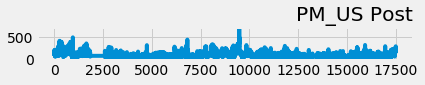

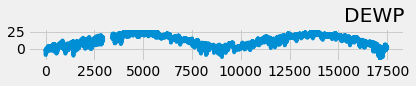

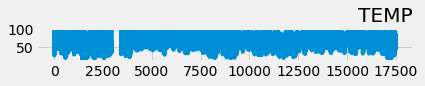

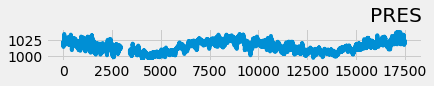

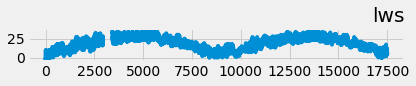

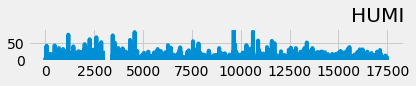

In [4]:
plt.figure()
col_nums = dataset.shape[1]

for i in range(col_nums):
    plt.subplot(col_nums, 1, i+1)
    plt.plot(dataset.values[:, i])
    plt.title(dataset.columns[i], y=1, loc='right')  # y is the interval width between each plot
    plt.show()

In [5]:
# make sure all the data is float type
values = dataset.values
values = values.astype('float32')
values

array([[ 6.800e+01, -3.000e+00,  8.019e+01,  1.022e+03,  0.000e+00,
         1.000e+00],
       [ 6.800e+01, -1.000e+00,  1.000e+02,  1.021e+03, -1.000e+00,
         0.000e+00],
       [ 6.800e+01, -3.000e+00,  9.285e+01,  1.021e+03, -2.000e+00,
         1.000e+00],
       ...,
       [ 2.500e+02,  3.000e+00,  8.106e+01,  1.026e+03,  6.000e+00,
         2.000e+00],
       [ 2.690e+02,  3.000e+00,  8.689e+01,  1.026e+03,  5.000e+00,
         0.000e+00],
       [ 2.340e+02,  3.000e+00,  8.689e+01,  1.026e+03,  5.000e+00,
         0.000e+00]], dtype=float32)

In [6]:
# normalize the data into [0,1] range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.09752548, 0.29545456, 0.7675156 , 0.5957451 , 0.075     ,
        0.01075269],
       [0.09752548, 0.3409091 , 1.        , 0.5744686 , 0.05      ,
        0.        ],
       [0.09752548, 0.29545456, 0.9160897 , 0.5744686 , 0.025     ,
        0.01075269],
       ...,
       [0.3624454 , 0.4318182 , 0.77772564, 0.680851  , 0.22500001,
        0.02150538],
       [0.3901019 , 0.4318182 , 0.84614486, 0.680851  , 0.2       ,
        0.        ],
       [0.33915576, 0.4318182 , 0.84614486, 0.680851  , 0.2       ,
        0.        ]], dtype=float32)

In [7]:
# Convert to supervided data
## Here, vari(t) is the 1 time step forard from vari(t-1)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  # number of columns in the original data
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
forward_steps = 1
reframed = series_to_supervised(scaled, forward_steps, 1)  # Here is where different from one-step forward
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,0.097525,0.295455,0.767516,0.595745,0.075,0.010753,0.097525,0.340909,1.000000,0.574469,0.050,0.000000
2,0.097525,0.340909,1.000000,0.574469,0.050,0.000000,0.097525,0.295455,0.916090,0.574469,0.025,0.010753
3,0.097525,0.295455,0.916090,0.574469,0.025,0.010753,0.097525,0.318182,0.916794,0.574469,0.050,0.010753
4,0.097525,0.318182,0.916794,0.574469,0.050,0.010753,0.097525,0.318182,1.000000,0.574469,0.025,0.000000
5,0.097525,0.318182,1.000000,0.574469,0.025,0.000000,0.097525,0.295455,1.000000,0.574469,0.000,0.010753
...,...,...,...,...,...,...,...,...,...,...,...,...
17492,0.411936,0.409091,0.844971,0.659575,0.175,0.000000,0.356623,0.409091,0.844971,0.659575,0.175,0.000000
17493,0.356623,0.409091,0.844971,0.659575,0.175,0.000000,0.292576,0.431818,0.846145,0.680851,0.200,0.000000
17494,0.292576,0.431818,0.846145,0.680851,0.200,0.000000,0.362445,0.431818,0.777726,0.680851,0.225,0.021505
17495,0.362445,0.431818,0.777726,0.680851,0.225,0.021505,0.390102,0.431818,0.846145,0.680851,0.200,0.000000


In [9]:
dataset.shape[0]

17497

In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = 19*31*24  # raw_data has 4 years data reocred in hourly basis, here I'm using first 3 years as training
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

feature_num = dataset.shape[1]  # number of features

# split into input and outputs
## predict multiple labels
train_X, train_y = train[:, :feature_num*forward_steps], train[:, -feature_num]  
test_X, test_y = test[:, :feature_num*forward_steps], test[:, -feature_num]

# reshape input to be 3D [samples, timesteps, dimensions]
train_X = train_X.reshape((train_X.shape[0], forward_steps, feature_num))  # Also different from one-step forward
test_X = test_X.reshape((test_X.shape[0], forward_steps, feature_num))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14136, 1, 6) (14136,) (2865, 1, 6) (2865,)


In [11]:
# LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')  # using Mean Absolute Error here

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 14136 samples, validate on 2865 samples
Epoch 1/50
 - 1s - loss: 0.0610 - val_loss: 0.0519
Epoch 2/50
 - 0s - loss: 0.0484 - val_loss: 0.0400
Epoch 3/50
 - 0s - loss: 0.0345 - val_loss: 0.0350
Epoch 4/50
 - 0s - loss: 0.0240 - val_loss: 0.0186
Epoch 5/50
 - 0s - loss: 0.0165 - val_loss: 0.0152
Epoch 6/50
 - 0s - loss: 0.0153 - val_loss: 0.0143
Epoch 7/50
 - 0s - loss: 0.0151 - val_loss: 0.0143
Epoch 8/50
 - 0s - loss: 0.0150 - val_loss: 0.0143
Epoch 9/50
 - 0s - loss: 0.0150 - val_loss: 0.0143
Epoch 10/50
 - 0s - loss: 0.0150 - val_loss: 0.0143
Epoch 11/50
 - 0s - loss: 0.0150 - val_loss: 0.0143
Epoch 12/50
 - 0s - loss: 0.0150 - val_loss: 0.0143
Epoch 13/50
 - 0s - loss: 0.0151 - val_loss: 0.0143
Epoch 14/50
 - 0s - loss: 0.0151 - val_loss: 0.0143
Epoch 15/50
 - 0s - loss: 0.0150 - val_loss: 0.0143
Epoch 16/50
 - 0s - loss: 0.0149 - val_loss: 0.0143
Epoch 17

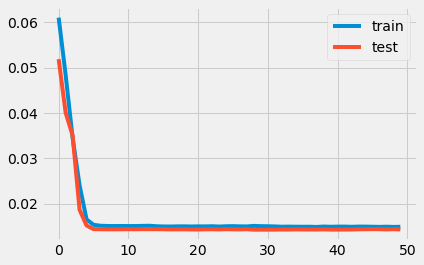

In [15]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
from math import sqrt
from numpy import concatenate

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], feature_num*forward_steps))  # Different from one-step forward

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(feature_num-1):]), axis=1)  # Predict multiple labels
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(feature_num-1):]), axis=1)  # Predict multiple labels
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.930
